## The command to copy data from blob to compute

az storage blob directory download -c am100-data --destination-path "." --source-path "proto_1" --account-name aq1ds2storage --recursive

In [1]:
# %pip install opencv-python albumentations pycocotools

In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from utils.engine import train_one_epoch, evaluate

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configure Path

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

DATABASE_BASE = "../database/proto_2/"
train_csv_path = DATABASE_BASE + "train.csv"
test_csv_path = DATABASE_BASE + "val.csv"
train_image_path = DATABASE_BASE + "train"
test_image_path = DATABASE_BASE + "val"
model_save_path = "trained_model/rgb_proto_2/"
model_save_name = model_save_path + "rcnn_b4_vanila"
pretrained_model = "trained_model/gray_proto_1/fasterrcnn_resnet50_fpn_4ep_best.pt"

## Check data

In [3]:
train_csv = pd.read_csv(train_csv_path)
print(train_csv.shape)
train_csv.head()

(5677, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,20190603_113916_00111CF01807_FRA-2019-A4T-0038...,1392,1040,tuna_whole,0,79,85,182
1,20190603_113916_00111CF01807_FRA-2019-A4T-0038...,1392,1040,tuna_whole,208,354,360,605
2,20190603_113916_00111CF01807_FRA-2019-A4T-0038...,1392,1040,tuna_whole,213,3,316,182
3,20190603_113916_00111CF01807_FRA-2019-A4T-0038...,1392,1040,tuna_whole,227,2,420,256
4,20190603_113916_00111CF01807_FRA-2019-A4T-0038...,1392,1040,tuna_whole,272,210,452,499


In [4]:
filename_un = train_csv["filename"].unique()
print(len(filename_un))

562


In [5]:
test_csv = pd.read_csv(test_csv_path)
print(test_csv.shape)
test_csv.head()

(1977, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,20170531_082135_00111CF017F5_FRA-2017-AUT-0025...,1392,1040,tuna_whole,514,653,591,832
1,20170531_082135_00111CF017F5_FRA-2017-AUT-0025...,1392,1040,tuna_whole,533,557,667,862
2,20170531_082135_00111CF017F5_FRA-2017-AUT-0025...,1392,1040,tuna_whole,587,278,671,488
3,20210603_105101157_220308_MLT-2021-AUT-CG-001-...,1392,1040,tuna_whole,432,892,570,1023
4,20210603_105101157_220308_MLT-2021-AUT-CG-001-...,1392,1040,tuna_whole,439,254,653,740


In [6]:
categories = train_csv["class"].unique()
print(categories)

['tuna_whole']


## Encoding classes to integers
* 0 is for background

In [7]:
# Encoding functions
class LabelMap:
    def __init__(self, categories):
        self.map_dict = {}
        self.reverse_map_dict={}
        for i, cat in enumerate(categories):
            self.map_dict[cat] = i + 1
            self.reverse_map_dict[i] = cat
    def fit(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df
    def inverse(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df

In [8]:
label_map = LabelMap(categories)

In [9]:
train_csv = label_map.fit(train_csv, "class")
train_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,20190603_113916_00111CF01807_FRA-2019-A4T-0038...,1392,1040,1,0,79,85,182
1,20190603_113916_00111CF01807_FRA-2019-A4T-0038...,1392,1040,1,208,354,360,605
2,20190603_113916_00111CF01807_FRA-2019-A4T-0038...,1392,1040,1,213,3,316,182
3,20190603_113916_00111CF01807_FRA-2019-A4T-0038...,1392,1040,1,227,2,420,256
4,20190603_113916_00111CF01807_FRA-2019-A4T-0038...,1392,1040,1,272,210,452,499


In [10]:
test_csv = label_map.fit(test_csv, "class")
test_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,20170531_082135_00111CF017F5_FRA-2017-AUT-0025...,1392,1040,1,514,653,591,832
1,20170531_082135_00111CF017F5_FRA-2017-AUT-0025...,1392,1040,1,533,557,667,862
2,20170531_082135_00111CF017F5_FRA-2017-AUT-0025...,1392,1040,1,587,278,671,488
3,20210603_105101157_220308_MLT-2021-AUT-CG-001-...,1392,1040,1,432,892,570,1023
4,20210603_105101157_220308_MLT-2021-AUT-CG-001-...,1392,1040,1,439,254,653,740


## Torch Dataset Creation

In [11]:
class AnimalDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_path, categories, transforms=None,**kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.image_path = image_path
        self.categories = categories
        self.images = self.df["filename"].unique()
        self.transforms = transforms
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_file = os.path.join(self.image_path, self.images[idx])
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0
        image_data = self.df[self.df['filename'] == self.images[idx]]
        labels = torch.as_tensor(image_data["class"].values, dtype=torch.int64)
        xmins = image_data["xmin"].values
        ymins = image_data["ymin"].values
        xmaxs = image_data["xmax"].values
        ymaxs = image_data["ymax"].values
        boxes = torch.as_tensor(np.stack([xmins, ymins, xmaxs, ymaxs], axis=1), dtype=torch.float32)
        areas = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = transformed["image"]
            target["boxes"] = torch.as_tensor(transformed["bboxes"],dtype=torch.float32)
        return torch.as_tensor(img, dtype=torch.float32), target
    def get_height_and_width(self, image):
        image_data = self.df.loc[self.df['filename'] == image]
        return image_data["width"].values[0], image_data["height"].values[0]

## Data Augmentation

In [12]:
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    # A.augmentations.geometric.transforms.Affine(scale=0.5, p=0.3,shear=(20), translate_percent=0.2),
    # A.ISONoise(p=0.2),
    # A.GaussNoise(p=0.1),
    # A.CLAHE(p=0.1),
    # A.CenterCrop(height=700, width=1000, p=0.3),
    # A.HueSaturationValue(p=0.1),
    ToTensorV2(p=1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [13]:
transform_test = A.Compose([
    ToTensorV2(p=1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

## Dataloader creation

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
train_dataset = AnimalDataset(train_csv, train_image_path, categories, transform_train)
test_dataset = AnimalDataset(test_csv, test_image_path, categories, transform_test)

In [17]:
data_loader_train = torch.utils.data.DataLoader(
        train_dataset, batch_size=4, shuffle=True, num_workers=4,
        collate_fn=collate_fn)
    
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

## Plot images from dataloader

In [18]:
def plot_images(images, targets):
    for image, target in zip(images, targets):
        sample = image.permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        boxes = target["boxes"].cpu().numpy().astype(np.int32)
        for box in boxes:
            cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
        ax.set_axis_off()
        ax.imshow(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train batch


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


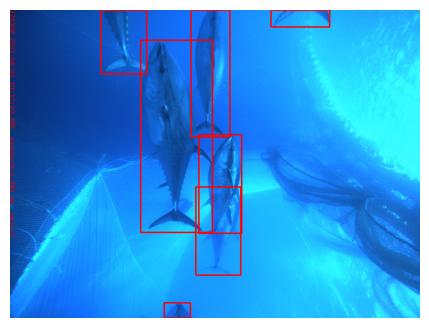

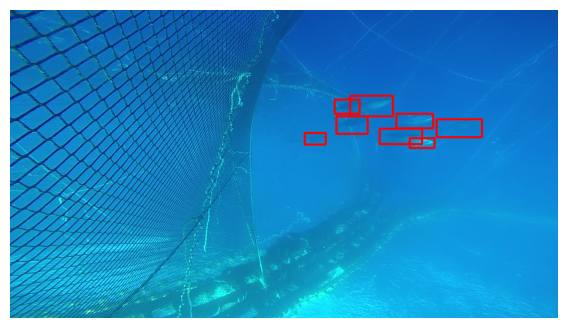

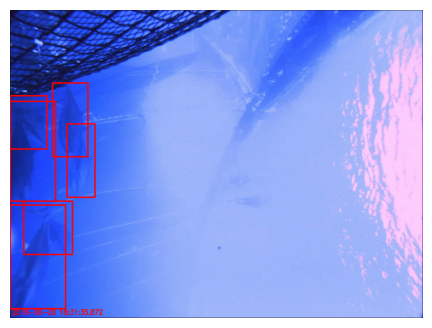

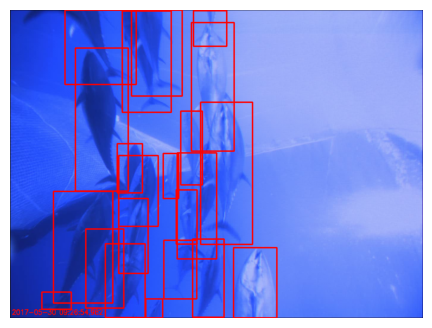

In [19]:
images, targets = next(iter(data_loader_train))
print("Train batch")
plot_images(images, targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test batch


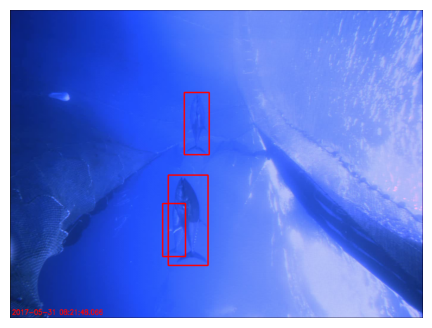

In [20]:
images, targets = next(iter(data_loader_test))
print("test batch")
plot_images(images, targets)

## Training

import model from torchvision library </br>
https://pytorch.org/vision/0.11/models.html

In [21]:
num_classes = len(categories)+1 # add background class

In [22]:
import torchvision.models.detection as torch_det

detection_model = torch_det.fasterrcnn_resnet50_fpn(pretrained=True)

# ... Alternatives ...
# detection_model = torch_det.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
# detection_model = torch_det.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# detection_model = torch_det.ssdlite320_mobilenet_v3_large(num_classes=num_classes)
# detection_model = torch_det.ssd300_vgg16(num_classes=num_classes)
# detection_model = torch_det.retinanet_resnet50_fpn(num_classes=num_classes)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


adjust classes

In [23]:
# for FastRCNN series... 
in_features = detection_model.roi_heads.box_predictor.cls_score.in_features
detection_model.roi_heads.box_predictor = torch_det.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

GPU load try and mount the model

In [24]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [25]:
# if you have pre-trianed model
# detection_model.load_state_dict(torch.load(pretrained_model))

detection_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Training and validation config

In [26]:
# !pip install wandb

In [30]:
import wandb
# from utils.wandbutils import log_to_wandb 
hm_api_key = "5bc9ab59d9422a7fc33e19d0de9014cda1ce4233"
wandb.login(key=hm_api_key)

# Initialize a new W&B run
wandb.init(
    project="mbt_RCNN", 
    name='proto_2_rgb',
)

# log config file to W&B
# wandb.save("data/hyp.scratch.custom.yaml")

# Add other hyperparameters as needed
wandb.config.epochs = 100
wandb.config.batch_size = 4
wandb.config.input_image_size = 1300
wandb.config.learning_rate = 0.001
wandb.config.momentum = 0.85
wandb.config.weight_decay = 0.0005

wandb.watch(detection_model, log_freq=100)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


[]

In [31]:
def log_to_wandb(train_result, eval_result):
    lr_f = float(str(train_result.meters['lr']).split()[0])
    loss_f = float(str(train_result.meters['loss']).split()[0])
    loss_classifier_f = float(str(train_result.meters['loss_classifier']).split()[0])
    loss_box_reg_f = float(str(train_result.meters['loss_box_reg']).split()[0])
    loss_objectness_f = float(str(train_result.meters['loss_objectness']).split()[0])
    loss_rpn_box_reg_f = float(str(train_result.meters['loss_rpn_box_reg']).split()[0])

    ap75 = eval_result["(AP)0.75"]
    ap50 = eval_result["(AP)0.50"]
    ap5095 = eval_result["(AP)0.50:0.95"]
    ar5095 = eval_result["(AR)0.50:0.95"]

    wandb.log({"learning rate":lr_f,
               "loss":loss_f,
               "loss_classifier":loss_classifier_f,
               "loss_box_reg":loss_box_reg_f,
               "loss_objectness":loss_objectness_f,
               "loss_rpn_box_reg":loss_rpn_box_reg_f,
               "Avg Precision 0.75":ap75,
               "Avg Precision 0.50":ap50,
               "Avg Precision 0.50:0.95":ap5095,
               "Avg Recall 0.50:0.95":ar5095,})

    if lr_f == 0 :
        return True
    return False

In [32]:
def training(model, train_loader, val_loader, epochs=10, patience=20):
    # init valiables
    cur_patience = patience
    min_loss = float('inf')
    
    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.85, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    for epoch in range(epochs):
        # train for one epoch, printing every 10 iterations
        train_result = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=120)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        eval_result = evaluate(model, val_loader, device=device)

        # wandb log
        lr_is_zero = log_to_wandb(train_result, eval_result.eval_result)

        # early stopping function
        cur_loss = float(str(train_result.meters['loss']).split()[0])

        if cur_loss < min_loss : 
            min_loss = cur_loss # update min loss
            torch.save(detection_model.state_dict(), model_save_name+'_best.pt') # save the best model
            cur_patience = patience # reset patience
            print("reset patience, saved model")
        else :
            cur_patience -= 1
            print("current patience:",cur_patience, "current loss: ",cur_loss, "best loss: ", min_loss)

        if cur_patience == 0 or lr_is_zero: # reach early stop
            print("early stop at epoch {} due to no loss improve for {} epochs".format(epoch,patience))
            wandb.config.epochs = epoch
            break

In [33]:
# Create directory if not exist
os.makedirs(model_save_path, exist_ok=True)

# start training
training(detection_model, data_loader_train, data_loader_test, epochs=wandb.config.epochs)

Epoch: [0]  [  0/141]  eta: 0:49:29  lr: 0.000008  loss: 1.9714 (1.9714)  loss_classifier: 0.9313 (0.9313)  loss_box_reg: 0.4560 (0.4560)  loss_objectness: 0.5496 (0.5496)  loss_rpn_box_reg: 0.0345 (0.0345)  time: 21.0589  data: 0.8900  max mem: 4927
Epoch: [0]  [120/141]  eta: 0:00:21  lr: 0.000864  loss: 0.5695 (0.9862)  loss_classifier: 0.1694 (0.3373)  loss_box_reg: 0.3597 (0.5384)  loss_objectness: 0.0160 (0.0811)  loss_rpn_box_reg: 0.0222 (0.0294)  time: 0.8931  data: 0.0149  max mem: 5193
Epoch: [0]  [140/141]  eta: 0:00:01  lr: 0.001000  loss: 0.5672 (0.9297)  loss_classifier: 0.1638 (0.3150)  loss_box_reg: 0.3365 (0.5108)  loss_objectness: 0.0256 (0.0751)  loss_rpn_box_reg: 0.0186 (0.0289)  time: 0.8694  data: 0.0147  max mem: 5193
Epoch: [0] Total time: 0:02:22 (1.0125 s / it)
creating index...
index created!
Test:  [  0/172]  eta: 0:01:01  model_time: 0.1588 (0.1588)  evaluator_time: 0.0029 (0.0029)  time: 0.3586  data: 0.1941  max mem: 5193
Test:  [100/172]  eta: 0:00:08  m

Exception in thread SockSrvRdThr:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/wandb/sdk/service/server_sock.py", line 99, in run
    sreq = self._sock_client.read_server_request()
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 274, in read_server_request
    data = self._read_packet_bytes()
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 248, in _read_packet_bytes
    rec = self._extract_packet_bytes()
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 230, in _extract_packet_bytes
    assert magic == ord("W")
AssertionError
Exception in thread SockSrvRdThr:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/pytho

Epoch: [10]  [120/141]  eta: 0:00:19  lr: 0.000001  loss: 0.3556 (0.3627)  loss_classifier: 0.1152 (0.1215)  loss_box_reg: 0.2131 (0.2168)  loss_objectness: 0.0072 (0.0096)  loss_rpn_box_reg: 0.0105 (0.0148)  time: 0.9263  data: 0.0156  max mem: 5193
Epoch: [10]  [140/141]  eta: 0:00:00  lr: 0.000001  loss: 0.3735 (0.3659)  loss_classifier: 0.1314 (0.1229)  loss_box_reg: 0.2335 (0.2182)  loss_objectness: 0.0095 (0.0097)  loss_rpn_box_reg: 0.0162 (0.0151)  time: 0.9496  data: 0.0153  max mem: 5193
Epoch: [10] Total time: 0:02:12 (0.9376 s / it)
creating index...
index created!
Test:  [  0/172]  eta: 0:01:24  model_time: 0.1503 (0.1503)  evaluator_time: 0.0022 (0.0022)  time: 0.4898  data: 0.3348  max mem: 5193
Test:  [100/172]  eta: 0:00:08  model_time: 0.0933 (0.0945)  evaluator_time: 0.0038 (0.0098)  time: 0.1134  data: 0.0045  max mem: 5193
Test:  [171/172]  eta: 0:00:00  model_time: 0.0939 (0.0942)  evaluator_time: 0.0057 (0.0101)  time: 0.1078  data: 0.0045  max mem: 5193
Test: Tot

## SAVE MODEL

In [34]:
# Save model (parameters only)
# torch.save(detection_model.state_dict(), model_save_name+'_last.pt')